### Task Description:
#### Train a ML method to recognize <font color=red> Plant Species </font> based on the different hyperspectral spectra (i.e., measuring leaf reflectance at different wavelengths in the range of 400 to 1000 nm).
- In the TXT file, you will find an experiment conducted on four different species (Cs = Cucumber, Sl = Tomato, Zm = Maize, Hv = Barley) grown under Fe-deficient conditions.
- Each row refers to a different plant, while the columns indicate the values at various wavelengths of the reflectance spectrum (from 400 to 1000 nm).
- The second column contains the plant species information ("Species": Cs is cucumber, Zm is maize, Sl is tomato, Hv is barley).
- The third column contains the treatment information ("Thesis": +N-Fe indicates iron deficiency, +N+Fe indicates iron sufficiency).

#### Methods
- Linear Logistic Regression
- Polynomial Logistic Regression
- Random Forest

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA

#### Load and Preprocess
- Drop the 'Leaf' column as it has the same value 'YL' for all rows
- Drop “Thesis” Column
- Encode the ‘Species' column (the ground-truth label)
- Separate the dataset into features and labels
- Check class imbalance in the whole dataset
- Check for missing values (there was none)
- Identify outliers using the IQR method ---> <font color=red> I did not drop them </font>
- Feature selection using Random Forest ---> <font color=red> 101 non-important features out of 204 </font>
- Scale the feature values (here, Columns) using Z-Score

Class Distribution:
Species
Cs    36
Sl    36
Hv    36
Zm    36
Name: count, dtype: int64


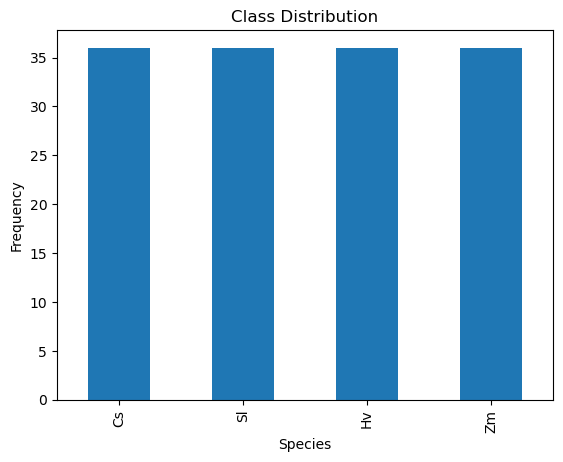

Columns with missing values: []

Outlier records/rows in the dataset:
Row numbers of outliers: [ 30  31  32  33  34  35  91  92  93  94  95  96  97  98  99 101 104 105
 106 107 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143]

Number of features with 0.0 importance: 101
Features with 0.0 importance: ['X414.63', 'X417.52', 'X487.14', 'X490.06', 'X507.56', 'X510.48', 'X516.33', 'X525.10', 'X530.96', 'X533.89', 'X536.82', 'X539.75', 'X542.68', 'X548.55', 'X551.49', 'X557.36', 'X560.30', 'X563.24', 'X566.18', 'X569.12', 'X572.07', 'X580.90', 'X583.85', 'X586.80', 'X589.75', 'X604.51', 'X607.46', 'X610.42', 'X613.38', 'X616.34', 'X622.26', 'X631.15', 'X643.01', 'X645.98', 'X651.92', 'X660.84', 'X666.79', 'X675.73', 'X684.67', 'X687.65', 'X696.61', 'X699.60', 'X714.55', 'X723.53', 'X735.53', 'X741.53', 'X756.56', 'X759.56', 'X768.60', 'X771.61', 'X774.62', 'X777.64', 'X786.68', 'X789.70', 'X792.72', 'X801.79', 'X810.86', 'X816.92', 'X822.98', 'X829.04', 'X832.07', 'X

In [17]:
# Step 1: Load the dataset
data = pd.read_csv('Dati_HIS_Serra_Cs_Hv_Sl_Zm_no_Fe.txt', delimiter='\t')

# Step 2: Preprocess the data
# Drop the 'leaf' column
data = data.drop(columns=['Leaf'])

# Separate the dataset into features and labels
X = data.iloc[:, 3:]  # Features
y = data['Species']  # Updated to use 'Species' as the target variable

# Check the distribution/imbalance of the target variable
class_distribution = data['Species'].value_counts()
print("Class Distribution:")
print(class_distribution)
# Visualize the class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Species')
plt.ylabel('Frequency')
plt.show()

# Encode the 'Species' column (target variable)
le = LabelEncoder()
y = le.fit_transform(y)

# Check for missing values
print(f"Columns with missing values: {data.columns[data.isnull().any()].tolist()}")

# Identify rows where at least one feature (column) has an outlier
print("\nOutlier records/rows in the dataset:")
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
outlier_rows = np.where(outliers)[0]
print("Row numbers of outliers:", outlier_rows)

# Feature selection using RandomForestClassifier
rf = RandomForestClassifier(n_estimators=15, random_state=42)
rf.fit(X, y)
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
zero_importance_features = feature_importances[feature_importances == 0.0].index.tolist()
print(f"\nNumber of features with 0.0 importance: {len(zero_importance_features)}")
print("Features with 0.0 importance:", zero_importance_features)
# print("\nFeature Importances:")
# print(feature_importances.sort_values(ascending=False))
# Remove zero importance features from X
X_reduced = X.drop(columns=zero_importance_features)
# print("\nX_reduced.shape is ", X_reduced.shape)

# Scale the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reduced)
# X_scaled = scaler.fit_transform(X)

# Apply PCA for further dimensionality reduction (optional)
# pca = PCA(n_components=10)  # Adjust n_components to retain desired variance
# X_pca = pca.fit_transform(X_scaled)
# print("\nExplained variance by each principal component:", pca.explained_variance_ratio_)

# Extra prints for debugging
print("X_scaled is",X_scaled.shape)
# print (X_scaled)
print("y is", y.shape)
# print(y)

### <font color=red> Disputed Cell! </font>
The following cell is related to "train & test" split which is under discussion
- Plan A: Blindly trust "train_test_split()" function
- Plan B: Manually, decompose the dataset based on plant type
- Plan C: ?!?

In [18]:
# Step 3: Train-Test Split

#Plan A
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.25, random_state=42)


# # plan B
# # Grouping the data by plant using X_scaled and y
# plant_groups_scaled = {
#     "Plant1": (X_scaled[0:36], y[0:36]),
#     "Plant2": (X_scaled[36:72], y[36:72]),
#     "Plant3": (X_scaled[72:108], y[72:108]),
#     "Plant4": (X_scaled[108:144], y[108:144])
# }

# # Plan B

# X_train_list = []
# y_train_list = []
# X_test_list = []
# y_test_list = []
# # Iterate over each plant species
# for plant in plant_groups_scaled.keys():
#     X = plant_groups_scaled[plant][0]
#     y = plant_groups_scaled[plant][1]
    
#     # Split the data for each plant species (e.g., 75% train, 25% test)
#     X_train_plant, X_test_plant, y_train_plant, y_test_plant = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)
    
#     # Append to the respective lists
#     X_train_list.append(X_train_plant)
#     y_train_list.append(y_train_plant)
#     X_test_list.append(X_test_plant)
#     y_test_list.append(y_test_plant)

# # Concatenate the lists to form the final train and test sets
# X_train = np.concatenate(X_train_list, axis=0)
# y_train = np.concatenate(y_train_list, axis=0)
# X_test = np.concatenate(X_test_list, axis=0)
# y_test = np.concatenate(y_test_list, axis=0)

# Confirm the shape of the train and test sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Plan C
# ...

X_train shape: (108, 103), y_train shape: (108,)
X_test shape: (36, 103), y_test shape: (36,)


#### Hyperparameter Tuning Using GridSearchCV , Model Training, and Evaluation
- Linear Logistic Regression </font>
- Polynomial Logistic Regression </font>
- Randomforest


----> <font color=red> Explicit Crossfold Validation (in the evaluation) or in GridSearch (Hyperparameter tuning)?? </font> I did the 2nd.

#### <font color=green> Standard Logistic Regression </font>

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}

Cross-Validation Scores from GridSearchCV:
     mean_test_score  std_test_score  \
0          0.722511        0.086237   
1          0.722511        0.086237   
2          0.731602        0.088623   
3          0.731169        0.086020   
4          0.823810        0.036312   
5          0.823810        0.036312   
6          0.833333        0.048128   
7          0.833333        0.048128   
8          0.926407        0.036835   
9          0.926407        0.036835   
10         0.926407        0.036835   
11         0.926407        0.036835   
12         0.963636        0.034015   
13         0.963636        0.034015   
14         0.963203        0.034142   
15         0.963203        0.034142   
16         0.963636        0.034015   
17         0.963636        0.034015   
18         0.963203        0.034142   
19         0.963203        0.034142   

                                               p

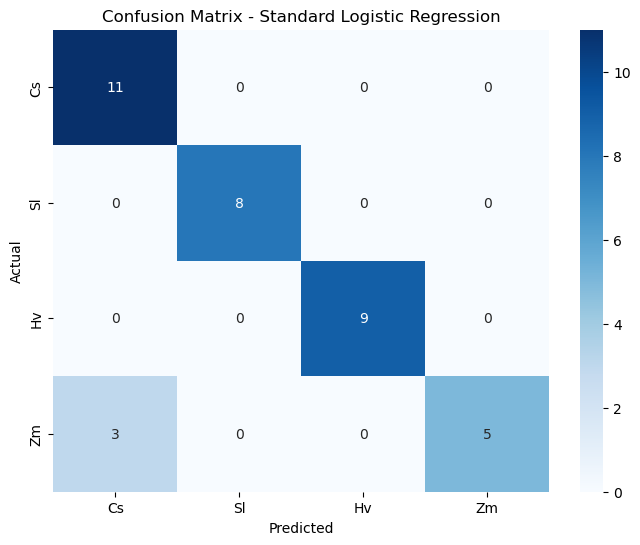

In [19]:
# Hyperparameter Tuning and Cross-Validation for Standard Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 30],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']  # Solvers that support multinomial
}
random_state = 42
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000, tol=1e-3, random_state=random_state), 
                              param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
best_params_lr = grid_search_lr.best_params_
print("Best parameters for Logistic Regression:", best_params_lr)

# Print Cross-Validation Scores from GridSearchCV
cv_results = pd.DataFrame(grid_search_lr.cv_results_)
print("\nCross-Validation Scores from GridSearchCV:\n", cv_results[['mean_test_score', 'std_test_score', 'params']])

# Initialize the best logistic regression model
model = LogisticRegression(**best_params_lr, max_iter=5000, tol=1e-3, random_state=random_state)

# Perform cross-validation
cv_scores_lr = cross_val_score(model, X_train, y_train, cv=5)
print("\nStandard Logistic Regression - Cross-Validation Scores:", cv_scores_lr)
print("Mean Cross-Validation Score:", cv_scores_lr.mean())

# Train the model on the entire training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
# y_pred_proba = model.predict_proba(X_test)  # Get the predicted probabilities

# Model Evaluation for Standard Logistic Regression
print("\nStandard Logistic Regression - Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred))

# # Print the predicted probabilities for the first few instances in the test set
# print("\nPredicted Probabilities (first 5 instances):")
# print(y_pred_proba.shape)
# print(y_pred_proba[:5])
      
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Cs", "Sl", "Hv", "Zm"], yticklabels=["Cs", "Sl", "Hv", "Zm"])
plt.title("Confusion Matrix - Standard Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### <font color=green> Polynomial Logistic Regression </font>

Best parameters for Polynomial Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}

Cross-Validation Scores from GridSearchCV:
     mean_test_score  std_test_score  \
0          0.871861        0.112549   
1          0.880952        0.097686   
2          0.861905        0.082347   
3          0.843290        0.079324   
4          0.926840        0.061472   
5          0.927273        0.068030   
6          0.889610        0.060976   
7          0.889610        0.060976   
8          0.945022        0.044456   
9          0.954545        0.049793   
10         0.889610        0.060976   
11         0.889610        0.060976   
12         0.935498        0.035944   
13         0.954545        0.049793   
14         0.889610        0.060976   
15         0.889610        0.060976   
16         0.898701        0.066354   
17         0.954545        0.049793   
18         0.889610        0.060976   
19         0.889610        0.060976   

                                  

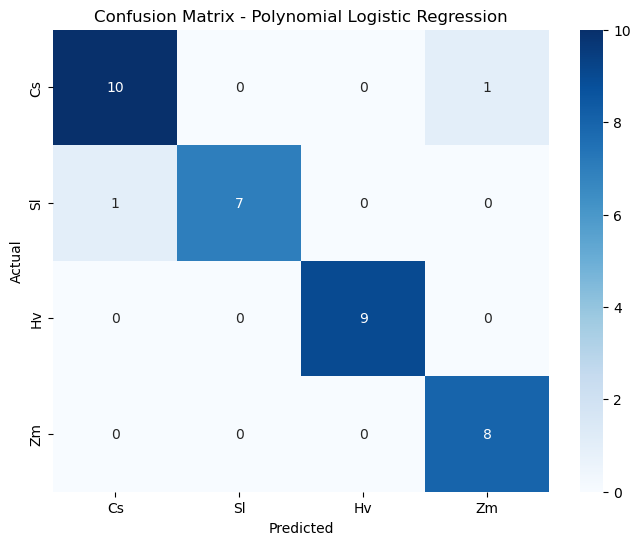

In [20]:
### Polynomial Logistic Regression ###
# Create polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_train)

# Hyperparameter Tuning and Cross-Validation for Polynomial Logistic Regression
param_grid_poly = {
    'C': [0.01, 0.1, 1, 10, 30],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']  # Solvers that support multinomial
}
random_state = 42
grid_search_poly = GridSearchCV(LogisticRegression(max_iter=1000, tol=1e-3, random_state=random_state), param_grid_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(X_poly, y_train)
best_params_poly = grid_search_poly.best_params_
print("Best parameters for Polynomial Logistic Regression:", best_params_poly)

# Print Cross-Validation Scores from GridSearchCV
cv_results_poly = pd.DataFrame(grid_search_poly.cv_results_)
print("\nCross-Validation Scores from GridSearchCV:\n", cv_results_poly[['mean_test_score', 'std_test_score', 'params']])

# Initialize the best polynomial logistic regression model
model_poly = LogisticRegression(**best_params_poly,max_iter=5000, tol=1e-3,random_state=random_state)

# Train the model on the entire training set
model_poly.fit(X_poly, y_train)

# Make predictions on the test set
y_pred_poly = model_poly.predict(poly.transform(X_test))
# y_pred_proba = model.predict_proba(X_test)  # Get the predicted probabilities

# Model Evaluation for Polynomial Logistic Regression
print("\nPolynomial Logistic Regression - Test Set Accuracy:", accuracy_score(y_test, y_pred_poly))
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_poly))

# print("\nPredicted Probabilities (first 5 instances):")
# print(y_pred_proba[:5])

# Confusion Matrix
conf_matrix_poly = confusion_matrix(y_test, y_pred_poly)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_poly, annot=True, fmt="d", cmap="Blues", xticklabels=["Cs", "Sl", "Hv", "Zm"], yticklabels=["Cs", "Sl", "Hv", "Zm"])
plt.title("Confusion Matrix - Polynomial Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### <font color=green> Random Forest </font>

Best parameters for Random Forest: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Cross-Validation Scores from GridSearchCV:
      mean_test_score  std_test_score  \
0           0.908658        0.095144   
1           0.917749        0.087965   
2           0.908225        0.086261   
3           0.899134        0.092641   
4           0.908658        0.095144   
..               ...             ...   
283         0.852814        0.071448   
284         0.825108        0.086833   
285         0.861905        0.075583   
286         0.862338        0.080356   
287         0.843723        0.092871   

                                                params  
0    {'max_depth': None, 'max_features': 'sqrt', 'm...  
1    {'max_depth': None, 'max_features': 'sqrt', 'm...  
2    {'max_depth': None, 'max_features': 'sqrt', 'm...  
3    {'max_depth': None, 'max_features': 'sqrt', 'm...  
4    {'max_depth': None, 'max_features': 's

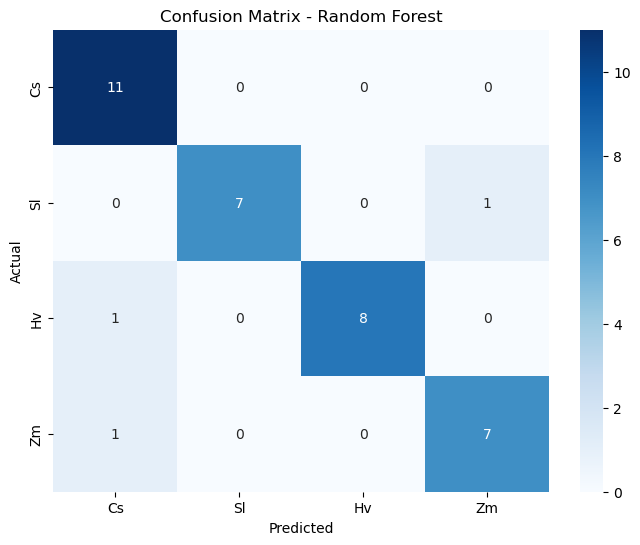

In [21]:
# Hyperparameter Tuning and Cross-Validation for Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
# Set a random_state for reproducibility
random_state = 42
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=random_state), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest:", best_params_rf)

# Print Cross-Validation Scores from GridSearchCV
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
print("\nCross-Validation Scores from GridSearchCV:\n", cv_results_rf[['mean_test_score', 'std_test_score', 'params']])

# Initialize the best Random Forest model
rf_model = RandomForestClassifier(**best_params_rf, random_state=random_state)

# Train the model on the entire training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Model Evaluation for Random Forest
print("\nRandom Forest - Test Set Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nPredicted Probabilities (first 5 instances):")
print(y_pred_proba[:5])
# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["Cs", "Sl", "Hv", "Zm"], yticklabels=["Cs", "Sl", "Hv", "Zm"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
